In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize


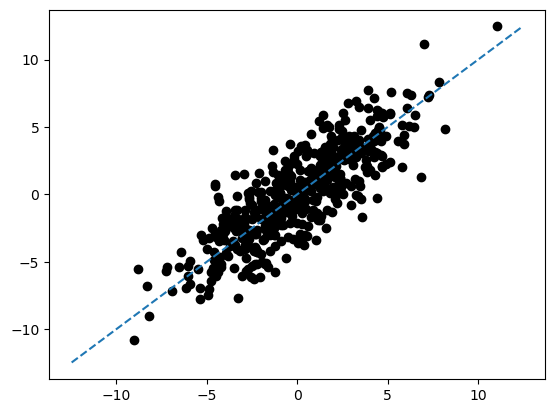

In [97]:
data = pd.read_csv('./Data/estimation.csv')
x_range = abs(data).max().max()
plt.scatter(data.present, data.estimate, color = 'black')
plt.plot([-x_range, x_range], [-x_range, x_range], linestyle = 'dashed')


In [95]:
def loglikhood(sigma):
    return norm.logpdf(data.estimate, loc = data.present, scale = sigma).sum()
sigma_range = np.arange(0.1, 10 + 0.02, 0.02)
logs = np.array([loglikhood(sigma) for sigma in sigma_range])
res_mle = minimize(lambda sigma: -loglikhood(sigma), 1)
res_mle.x, res_mle.fun, sigma_range[logs.argmax()] # 最大值是1.9

(array([1.89806367]), 1029.886386011684, 1.9000000000000004)

In [94]:
def loglikhood_pme(theta):
    sigma, sigma_s = theta
    return norm.logpdf(data.estimate, 
                       loc = (sigma**2 * data.present) / (sigma**2 + sigma_s**2), 
                       scale =(sigma_s**2 * sigma) / (sigma**2 + sigma_s**2)).sum()
sigma_range = np.arange(0.1, 10 + 0.02, 0.1)
idx = [(sigma, sigma_s) for sigma in sigma_range for sigma_s in sigma_range]
logs = np.array([loglikhood_pme(theta) for theta in idx])
res_pme = minimize(lambda sigma: -loglikhood_pme(sigma), (1, 1))
res_pme.x, res_pme.fun, idx[logs.argmax()]

(array([22.18560835,  6.75125771]), 1025.194461692248, (10.0, 4.8))

In [93]:
print(f'AIC: mle {res_mle.fun * 2 + 2 * 1:.3f}, pme {res_pme.fun * 2 + 2 * 2:.3f}') 
print(f'BIC: mle {res_mle.fun * 2 + np.log(500):.3f}, pme {res_pme.fun * 2 + 2 * np.log(500):.3f}') 

AIC: mle 2061.773, pme 2054.389
BIC: mle 2065.987, pme 2062.818


pre
-6    Axes(0.125,0.11;0.775x0.77)
-3    Axes(0.125,0.11;0.775x0.77)
 0    Axes(0.125,0.11;0.775x0.77)
 3    Axes(0.125,0.11;0.775x0.77)
 6    Axes(0.125,0.11;0.775x0.77)
Name: est, dtype: object

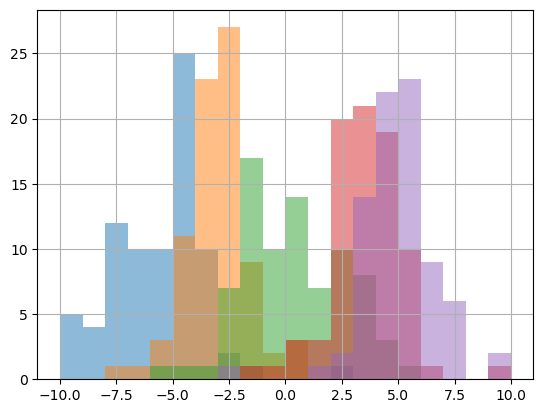

In [105]:
data = pd.read_csv('./Data/localization.csv')
data.groupby('pre')['est'].hist(bins = np.arange(-10, 11), alpha = 0.5)

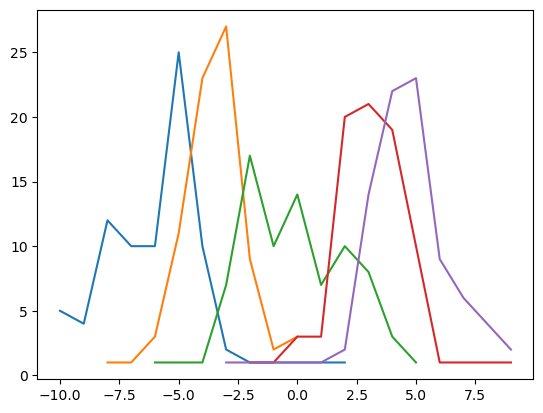

In [124]:
for key, datum in data.groupby('pre'):
    counts = datum.sort_values('est')['est'].value_counts(sort = False)
    plt.plot(counts.index, counts)

In [127]:
def loglikhood_M0():
    return - np.log(21) * len(data.est)
loglikhood_M0()

-1217.8089750893691

In [206]:

ests = np.concatenate([[-np.inf], np.arange(-9.5, 10.5), [np.inf]]).reshape(-1, 1)
pres = np.array([-6, -3, 0, 3, 6])
pre_idx = np.array(data.pre/3 + 2, dtype = np.int8)
est_idx = np.array(data.est + 10, dtype = np.int8)

def neg_loglikhood_M1(sigma):
    p = np.diff(norm.cdf(ests, pres, scale = sigma), axis=0)
    return -np.log(p[est_idx, pre_idx]).sum()
def neg_loglikhood_M2(theta):
    sigma, sigma_s = theta
    cdfs = norm.cdf(ests, loc = sigma_s**2 * pres /(sigma_s**2 + sigma**2), 
                    scale = (sigma_s**2 * sigma / (sigma_s**2 + sigma**2)))
    p = np.diff(cdfs, axis = 0).clip(1e-34, 1)
    return -np.log(p[est_idx, pre_idx]).sum()

res_mle = minimize(neg_loglikhood_M1, 1)
res_mle.x, res_mle.fun


(array([1.94516159]), 834.0858695603326)

In [205]:
res_pme = minimize(neg_loglikhood_M2, (1,1))
res_pme.x, res_pme.fun

(array([2.07484689, 7.20120478]), 828.5521697549576)

In [207]:
print(f'AIC: mle {res_mle.fun * 2 + 2 * 1:.3f}, pme {res_pme.fun * 2 + 2 * 2:.3f}') 
print(f'BIC: mle {res_mle.fun * 2 + np.log(500):.3f}, pme {res_pme.fun * 2 + 2 * np.log(500):.3f}')

AIC: mle 1670.172, pme 1661.104
BIC: mle 1674.386, pme 1669.534


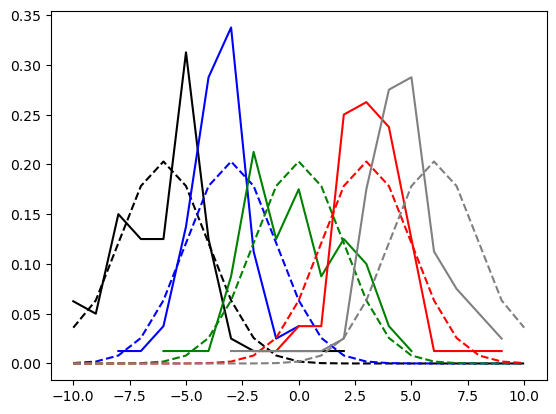

In [240]:
colormaps = ['black', 'blue', 'green', 'red', 'grey']
sigma = res_mle.x
p = np.diff(norm.cdf(ests, pres, scale = sigma), axis=0)
for i in range(5):
    plt.plot(np.arange(-10, 11), p[:, i], color = colormaps[i], linestyle = 'dashed')
    datum = data[data.pre == pres[i]]
    counts = datum.sort_values('est')['est'].value_counts(sort = False)
    plt.plot(counts.index, counts/80, color = colormaps[i])
    

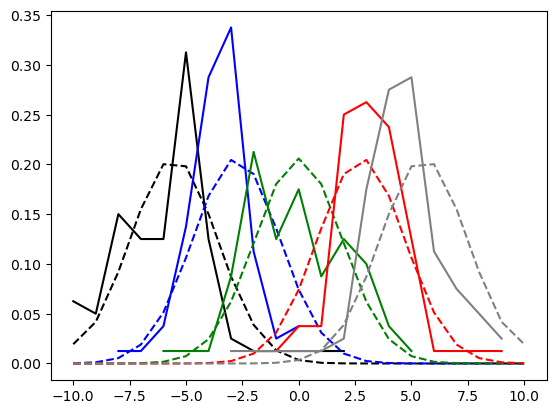

In [243]:
colormaps = ['black', 'blue', 'green', 'red', 'grey']
sigma, sigma_s = res_pme.x
cdfs = norm.cdf(ests, loc = sigma_s**2 * pres /(sigma_s**2 + sigma**2), 
                    scale = (sigma_s**2 * sigma / (sigma_s**2 + sigma**2)))
p2 = np.diff(cdfs, axis = 0)
for i in range(5):
    plt.plot(np.arange(-10, 11), p2[:, i], color = colormaps[i], linestyle = 'dashed')
    datum = data[data.pre == pres[i]]
    counts = datum.sort_values('est')['est'].value_counts(sort = False)
    plt.plot(counts.index, counts/80, color = colormaps[i])

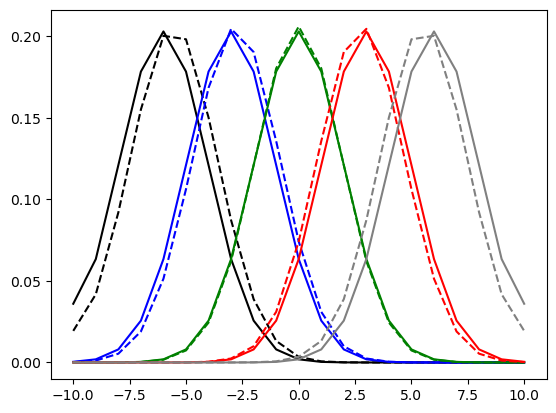

In [241]:
for i in range(5):
    plt.plot(np.arange(-10, 11), p2[:, i], color = colormaps[i], linestyle = 'dashed')
    plt.plot(np.arange(-10, 11), p[:, i], color = colormaps[i])

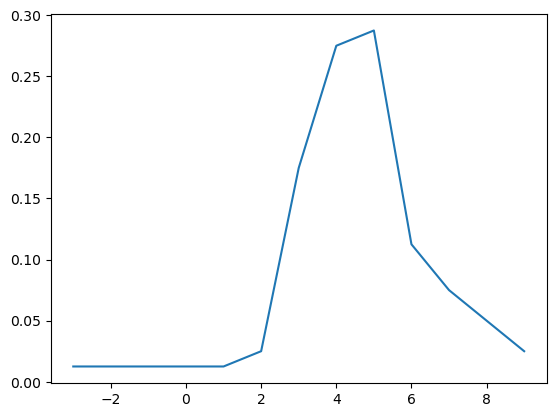